# Análise das Séries das Plataformas de Streaming

Optamos por essa base por já conhecer a mesma, uma vez que já trabalhamos com ela no projeto anterior, dessa forma, ela pode ser encontrada [nesse repositório](https://github.com/igorcj/AEDV).

In [1]:
library(readr)
library(WVPlots)
library(dplyr)
library(ggplot2)
library(tidyr)
library(stringr)
library(scales)
library(eulerr)
library(ggExtra)
require(ggplot2)
require(gtable)
require(grid)

Loading required package: wrapr


Attaching package: ‘dplyr’


The following object is masked from ‘package:wrapr’:

    coalesce


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following objects are masked from ‘package:wrapr’:

    pack, unpack



Attaching package: ‘scales’


The following object is masked from ‘package:readr’:

    col_factor


Loading required package: gtable

Loading required package: grid



Fazendo a leitura da base já tratada, com todos os merges já realizados.

In [2]:
shows <- read_csv('shows.csv') %>% mutate(Rotten_Tomatoes = Rotten_Tomatoes/10)
glimpse(shows)

Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  Title = col_character(),
  Year = col_double(),
  Age = col_character(),
  IMDb = col_double(),
  Rotten_Tomatoes = col_double(),
  Streamings = col_character(),
  Genre = col_character()
)




Rows: 462
Columns: 8
$ X1              <dbl> 0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16,…
$ Title           <chr> "breaking bad", "stranger things", "sherlock", "better…
$ Year            <dbl> 2008, 2016, 2010, 2015, 2005, 2011, 2005, 2013, 2005, …
$ Age             <chr> "18+", "16+", "16+", "18+", "16+", "18+", "16+", "18+"…
$ IMDb            <dbl> 9.5, 8.8, 9.1, 8.7, 8.9, 8.8, 8.4, 8.8, 9.2, 8.2, 8.7,…
$ Rotten_Tomatoes <dbl> 9.6, 9.3, 7.8, 9.7, 8.1, 8.3, 9.3, 9.2, 10.0, 8.1, 9.4…
$ Streamings      <chr> "Netflix", "Netflix", "Netflix", "Netflix", "Netflix",…
$ Genre           <chr> "crime,drama,thriller", "horror,mystery,scifi,fantasy"…


Podemos inicialmente fazer uma análise cruzando as notas que cada série recebeu e classificando, por meio das notas, como a série se saiu.

In [3]:
data <- shows %>% select(IMDb, Rotten_Tomatoes) %>% 
                  within(Contagem <- ave(IMDb,
                                         list(IMDb, Rotten_Tomatoes),
                                         FUN = length)) %>% 
                  unique() %>% 
                  arrange(-IMDb) %>% 
                  mutate(Resultado = ifelse(IMDb > 6 & Rotten_Tomatoes > 6,
                                            'Agradou a todos',
                                            ifelse(IMDb > 6,
                                                   'Agradou a critica',
                                                   ifelse(Rotten_Tomatoes > 6,
                                                          'Agradou o público',
                                                          'Fracassou')))) %>% 
                  mutate(Resultado = factor(as.character(Resultado),
                                            levels = c('Agradou a todos',
                                                       'Agradou a critica',
                                                       'Agradou o público',
                                                       'Fracassou')))

head(data)

IMDb,Rotten_Tomatoes,Contagem,Resultado
<dbl>,<dbl>,<dbl>,<fct>
9.5,9.6,1,Agradou a todos
9.3,9.3,1,Agradou a todos
9.2,10.0,1,Agradou a todos
9.1,7.8,1,Agradou a todos
9.1,10.0,2,Agradou a todos
8.9,8.1,1,Agradou a todos


Para visualizar esse dados, as notas e os desempenhos das séries, bem como a quantidade de séries com essas mesmas notas e desempenho, escolhemos o gráfico de dispersão, uma vez que os próxios dados estão em escala numérica. Para dar uma noção da quantidade optamos por colocar o tamanho de cada ponto sendo proporcional a quantidade de séries com aquelas notas. Por fim, o resultado obtido com as notas é destacado por meio das cores. A paleta de cores aplicada é a default do R mesmo, ilustrando a facilidade de criar um gráfico com essa ferramenta.

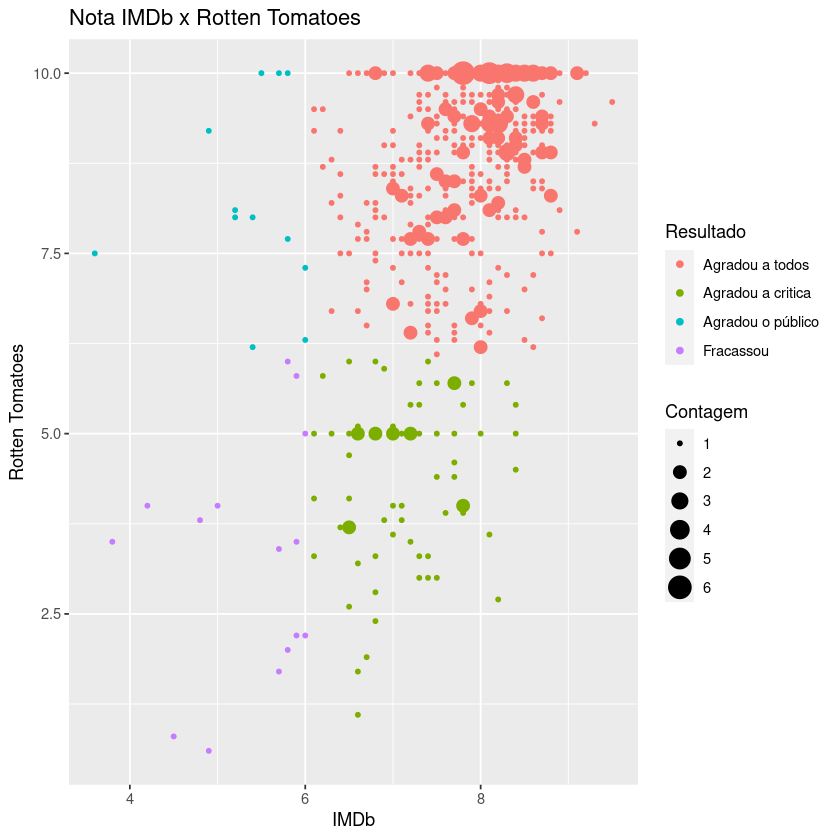

In [4]:
data %>% ggplot(aes(x = IMDb, y = Rotten_Tomatoes, size = Contagem, color = Resultado)) +
labs(x = 'IMDb', y = 'Rotten Tomatoes', title = 'Nota IMDb x Rotten Tomatoes') +
geom_point()

Uma outra ideia para plotar a mesma informação se dá por um heatmap, o qual também possibilita cruzar duas séries numéricas e fazer a representação da quantidade por meio da cor do ponto, uma vez que utilizadno o tamanho os dados podem se sobrepor, como visto acima. Note que não plotamos mais o resultado, mas isso não é muito relevante, uma vez que essa divisão se dá apenas em função das notas (conforme são maiores ou menores que 6).

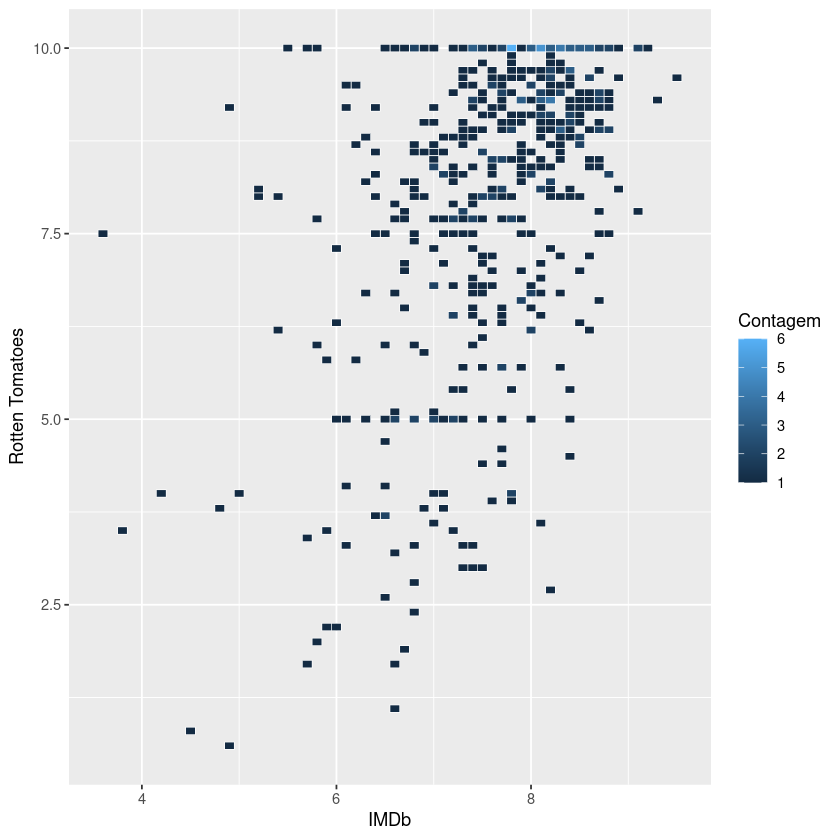

In [5]:
heatmap <- ggplot(data, aes(x = IMDb, y = Rotten_Tomatoes, fill = Contagem)) +
           geom_tile(colour = 'white', size = 0.2) +
           labs(x = 'IMDb', y = 'Rotten Tomatoes')

heatmap

Podemos expandir a ideia do gráfico acima, possibilitando um melhor entendimento das notas ao agrupar as mesmas com bins maiores e, após isso, criando um heatmap com as distribuições marginais das notas. Dessa forma, nosso gráfica não só mostra como as notas estão distribuídas bidimensionalmente, mas também unidimensionalmente para cada nota. Note que o heatmap é bem mais favorável a essa visualização que um scatter plot, uma vez que haveria sobreposição das bolinhas nesse gráfico. Para a distribuição marginal o gráfico de barras foi a escolha pela simplicidade de analisar a distribuição da mesma, uma vez que é mais simples que analisar por meio de linhas simples.

`summarise()` has grouped output by 'IMDb'. You can override using the `.groups` argument.



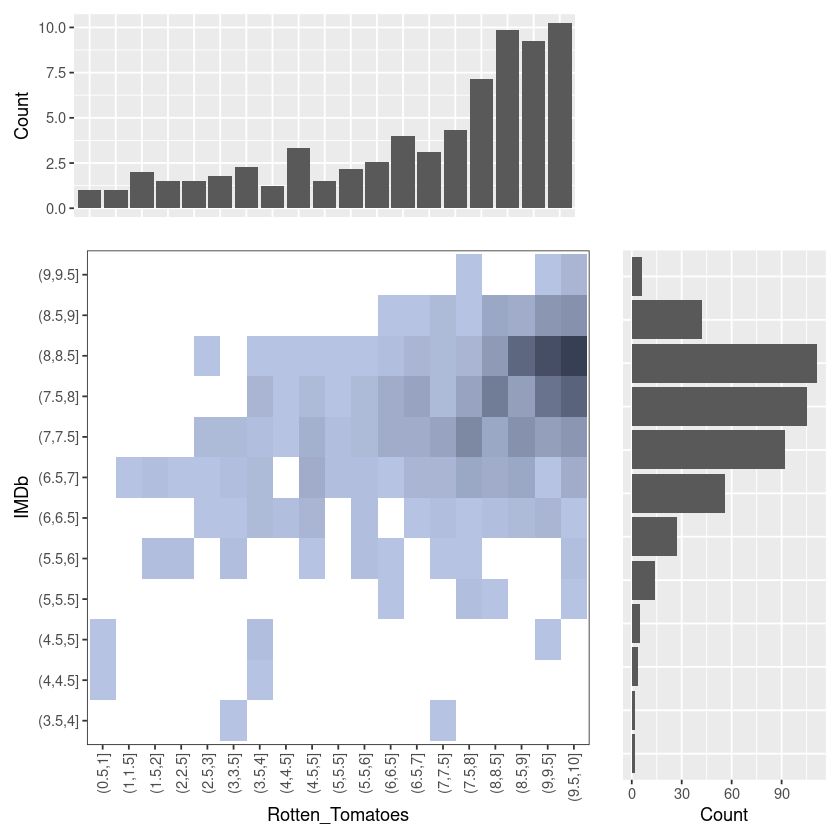

In [6]:
# Prepare the data
df <- data %>% mutate(IMDb = cut(IMDb, breaks = 0:20/2),
                Rotten_Tomatoes = cut(Rotten_Tomatoes, breaks = 0:20/2)) %>%
    group_by(IMDb, Rotten_Tomatoes) %>%
    summarise(Count = sum(Contagem))


# plot the heatmap
gg_hm = df %>% 
    ggplot(aes(y = IMDb, x = Rotten_Tomatoes, fill = Count)) + 
    geom_tile() + theme_bw() +
    scale_fill_gradient(low="#b6c3e2", high="#363F54") +
    theme(plot.margin = unit(c(3,3,3,3), "mm"),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          axis.text.x = element_text(angle = 90,
                                     vjust = 0.5,
                                     hjust=1))

gg_rows = df %>% 
    group_by(Rotten_Tomatoes) %>% 
    summarize(Count = mean(Count)) %>% 
    ggplot(aes(x = Rotten_Tomatoes,y = Count)) + 
    geom_bar(stat = "identity", position = "dodge") +
    theme(plot.margin = unit(c(3,3,3,3), "mm"),
          axis.title.x=element_blank(),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank())


gg_cols = df %>% 
    group_by(IMDb) %>% 
    summarize(Count = sum(Count)) %>% 
    ggplot(aes(x = IMDb, y = Count))+ 
    geom_bar(stat = "identity", position = "dodge") + 
    coord_flip() +
    theme(plot.margin = unit(c(3,3,3,3), "mm"),
          axis.title.y=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks.y=element_blank())

## plot heatmap without legend
g <- ggplotGrob(gg_hm + theme(legend.position="none"))

## add column and put column barplot within
g <- gtable_add_cols(g, unit(5,"cm"))
g <- gtable_add_grob(g, ggplotGrob(gg_cols), 
                     t = 1, l=ncol(g), b=nrow(g), r=ncol(g))

## add row on top and put row barplot within
g <- gtable_add_rows(g, unit(5,"cm"), 0)
g <- gtable_add_grob(g, ggplotGrob(gg_rows),
                     t = 1, l=1, b=1, r=5) 

grid.newpage()
grid.draw(g)

Por fim elaboramos um Diagrama de Venn com as plataformas de cada série. A escolha por esse gráfico foi a mais simples, uma vez que o Diagrama de Venn é a melhor forma de ilustrar a relação entre os elementos de conjuntos e de suas interseções. A paleta de cores foi escolhida de modo a lembrar a plataforma que o conjunto representa.

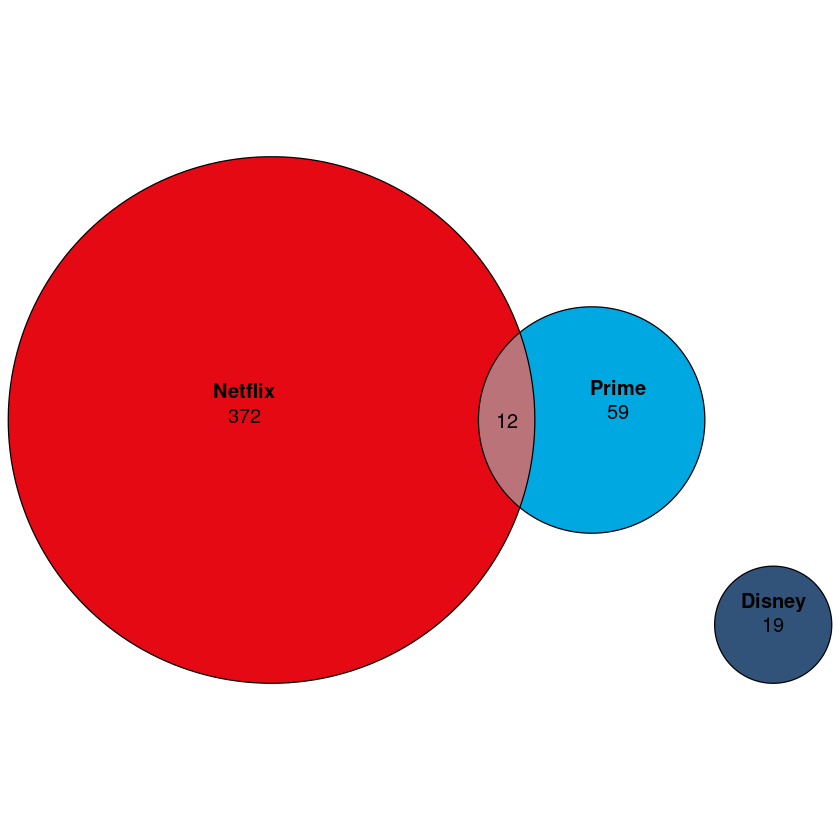

In [7]:
Netflix <- (shows %>% filter(grepl('Netflix', Streamings)))$Title
Prime <- (shows %>% filter(grepl('Prime', Streamings)))$Title
Disney <- (shows %>% filter(grepl('Disney', Streamings)))$Title

plot(euler(list(Netflix = Netflix,
               Prime = Prime,
               Disney = Disney)),
     quantities = TRUE,
     fills = c('#E50914','#00A8E1','#31537A'))

## Algumas análises

Durante a elaboração dos gráficos pode-se ver que o heatmap acaba se sobresaindo em relação ao scatter plot quando queremos mostrar a quantidade de elementos em um determinado ponto do plano (note que no scatter algumas bolinhas acabam se sobrepondo a outras, o que não acontece no heatmap).

Quanto ao dado em si, podemos ver que o público, em geral, avalia mais positivamente as séries (note que o pico da distribuição das notas do Rotten Tomatoes está nas notas acima de 8.5), enquanto a crítica é um pouco mais dura (o pico se encontra no intervalo de 7 a 8.5). Em contrapartida, mais séries recebem avaliações piores pelo público que pela crítica.

Por fim, o Diagrama de Venn mostra que a Netflix e a Amazon Prime apresentam algumas séries em comum, enquanto a Disney Plus detém apenas títulos exclusivos.

## Bibliotecas utilizadas

Além das bibliotecas do tidyverse acabamos utilizando algumas outras bibliotecas, como a eulerr e ggExtra, por exemplo. A primeira foi utilizada com o intuito de elaborar o Diagrama de Venn, enquanto a segunda foi utilizada para plotar a distribuição marginal das notas no heatmap.

## Aprendizado

Elaborar esses gráficos contribuiu positivamente para o aprendizado, seja reforçando alguns pontos vistos em listas ou seja buscando novas ferramentas que possibilitassem a gente elaborar gráficos mais trabalhados, como a inclusão da distruibição marginal ou a criação do Diagrama de Venn.

## Processo de Trabalho

Nossa dupla optou por fazer o trabalho utilizando o mesmo notebook e compartilhando o mesmo via github, assim os dois foram desenvolvendo o trabalho pouco a pouco, realizando commits e o outro membro da dupla vendo e alterando e/ou incluindo novos detalhes.